<h1>Projket staż M-bank 2021</h1>
<h2>Mateusz Jakubczak</h2>


In [128]:
# visualizatin 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import phik
from scipy import stats
import math
from pandas_profiling import ProfileReport
import statsmodels.stats.weightstats as st 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
from IPython.display import Image

import statsmodels.api as sm
from sklearn.datasets import make_blobs

%matplotlib inline

### Pierwsze co należy zrobić w analizie to przygotowac dane.


In [2]:
df =pd.read_csv("BankChurners.csv")
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

## Mamy dwie zmienne gdzie, patrząc na ich nazwę są wynikiem modelu.
Ponieważ nie znamy samych parametrów tego modelu poza tym jakie zmienne zostały w nim urzyte nie możemy użyć tych zmiennych, jak i nie ma ich w specyfikacji samego zadania, dlatego pozbywamy się tych zmiennych. Wyrzucamy równiez zmienną CLIENTNUM, która stanowi tylko index dla naszych danych. 

In [3]:
df = df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",          "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1","CLIENTNUM"],
             axis = 1)

Mamy parę nie zgodnych typów kategorycznych rozpoznacych jako obiekty. Poprawiamy to

In [4]:
df = df.convert_dtypes()

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  string 
 1   Customer_Age              10127 non-null  Int64  
 2   Gender                    10127 non-null  string 
 3   Dependent_count           10127 non-null  Int64  
 4   Education_Level           10127 non-null  string 
 5   Marital_Status            10127 non-null  string 
 6   Income_Category           10127 non-null  string 
 7   Card_Category             10127 non-null  string 
 8   Months_on_book            10127 non-null  Int64  
 9   Total_Relationship_Count  10127 non-null  Int64  
 10  Months_Inactive_12_mon    10127 non-null  Int64  
 11  Contacts_Count_12_mon     10127 non-null  Int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  Int64  
 14  Avg_Op

None

Sprawdzamy czy są duplikaty oraz puste warotścoi

In [6]:

display(pd.DataFrame([df.duplicated().sum()],columns=["Ilość duplikatów"]).style.hide_index())

Dane sa czyse i możemy z nimi pracować

# Wizualizacja danych

In [7]:
#profile = ProfileReport(df, config_file="config.yml")


In [8]:
#profile.to_notebook_iframe()


## Wnioski z eksprolacji

1. Mamy podejrzanie dużą ilość rachunków które mają daokładnie 3 lata (36 miesięcy)
2. Wartości typu NaN są nie prowidlo zakfalifikowane jako "Unknow"
3. Nasza zmienna endogeniczna jest nie zbalansowana
4. Mamy podejrzanie wysoką ilość klientów z wiekiem około 48 lat
5. Zmienna Card_Category jest wysoce nie zbalansaowan, 20 platynowych kart do 9.5 tyś niebieskich
6. Credit limit posiada dystrybucje z grubym ogonem
7. Większość zmiennych nie przyjmuje rozkładu normalnego

## Sprawdzmy korelacje naszej  zmiennej endogenicznej
poniża kolumna przedstawia korelecej typu phik, im warość jest bliższa 1 tym bardziej skorelowane ze sobą są dwie wartości. 

In [9]:

for c in ["Attrition_Flag","Gender","Education_Level","Marital_Status","Income_Category","Card_Category"]:
    df[c] = df[c].replace("Unknown",np.nan,method="pad")
    df[c] = df[c].astype("category")


In [42]:
for c in df.columns:
    if df[c].dtype.__str__() == "Int64":
        df[c] = df[c].astype("float64")

In [10]:
df["Education_Level"].value_counts()

Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [11]:
display(df.isna().sum().to_frame("Ilośc NA"))

Ilośc NA
Attrition_Flag                   0
Customer_Age                     0
Gender                           0
Dependent_count                  0
Education_Level               1519
Marital_Status                 749
Income_Category               1112
Card_Category                    0
Months_on_book                   0
Total_Relationship_Count         0
Months_Inactive_12_mon           0
Contacts_Count_12_mon            0
Credit_Limit                     0
Total_Revolving_Bal              0
Avg_Open_To_Buy                  0
Total_Amt_Chng_Q4_Q1             0
Total_Trans_Amt                  0
Total_Trans_Ct                   0
Total_Ct_Chng_Q4_Q1              0
Avg_Utilization_Ratio            0

### Mamy parę wartości typu NA w zmiennych kategorycznych. W dalszej części analizy zdecydujemy co z nimi zrobimy, bo może się okazać że nie wykorzystamy tych kolumn do dalszej analizy. 

# Obecny stan kolumn

In [12]:
corr = df.phik_matrix()
display(corr["Attrition_Flag"].sort_values(ascending = False).to_frame())

interval columns not set, guessing: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


Attrition_Flag
Attrition_Flag                  1.000000
Total_Trans_Ct                  0.592470
Total_Revolving_Bal             0.522422
Total_Trans_Amt                 0.423372
Total_Ct_Chng_Q4_Q1             0.409053
Avg_Utilization_Ratio           0.314541
Total_Relationship_Count        0.230833
Contacts_Count_12_mon           0.223812
Total_Amt_Chng_Q4_Q1            0.184180
Months_Inactive_12_mon          0.183537
Gender                          0.055962
Education_Level                 0.039007
Customer_Age                    0.031183
Dependent_count                 0.029239
Credit_Limit                    0.028030
Months_on_book                  0.025403
Avg_Open_To_Buy                 0.025286
Income_Category                 0.024901
Marital_Status                  0.011258
Card_Category                   0.000000

### Wnioski z korelacji 
1. Mamy wysoką korelacje z ilością wykonanych tranzakcji a zmienną endogeniczną 
2. Zmienne z NA mają bardzo niską korelacje z zmienną endogeniczną

# Badnaie hipotez 
1. Posiadacze wyszej kalsy karty mają mniejszą szansę na zamknięcie konta
2. Posiadacze konta wykonujący dużo tranzakcj mają mniejszą szanse na zamknięcie konta 
3. Posiadacze konta przez długi czas maja mniejszą szanse odejścia 

In [13]:
#Hipoteza 1 
df.Card_Category.value_counts()
df_h1 = df.Card_Category == "Blue"
df_h1_prem = df.Card_Category == "Platinum"

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [14]:
df["Attrition_Flag_onehot"] = pd.get_dummies(df["Attrition_Flag"]).iloc[:,0]

df[["Attrition_Flag","Attrition_Flag_onehot"]].head()

Attrition_Flag  Attrition_Flag_onehot
0  Existing Customer                      0
1  Existing Customer                      0
2  Existing Customer                      0
3  Existing Customer                      0
4  Existing Customer                      0

## Z one hot encodingu wynika że obecny konsument ma przypisane 0, natomiast z zamkniętym kontem ma wartość 1 

In [15]:
prob_blue = df[df_h1]["Attrition_Flag"].value_counts()
d_blue = {
"prawdobienstwo odejścia":prob_blue.iloc[1] / prob_blue.iloc[0],
 "Liczebnosc populacji":prob_blue.iloc[1] + prob_blue.iloc[0]
}
display(pd.DataFrame.from_dict(d_blue,orient='index'))

0
prawdobienstwo odejścia     0.191866
Liczebnosc populacji     9436.000000

In [16]:
prob_rest = df[~df_h1]["Attrition_Flag"].value_counts()
d_rest = {
"prawdobienstwo odejścia":prob_rest.iloc[1] / prob_rest.iloc[0],
 "Liczebnosc populacji":prob_rest.iloc[1] + prob_rest.iloc[0]
}
display(pd.DataFrame.from_dict(d_rest,orient='index'))

0
prawdobienstwo odejścia    0.185249
Liczebnosc populacji     691.000000

In [17]:

display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy Blue a Platinum":
st.ttest_ind(df[df_h1_prem]["Attrition_Flag_onehot"],df[df_h1]["Attrition_Flag_onehot"], alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy Blue a P...  0.139738

In [18]:

display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy Blue a pozostałymi":
st.ttest_ind(df[~df_h1]["Attrition_Flag_onehot"],df[df_h1]["Attrition_Flag_onehot"], alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy Blue a p...  0.626887

## Możemy odrzucic hipotezę że klasa wpływa na szansę zamknięcia konta 

# Hipoteza 2  
zakładamy że osoby wykonującę dużo tranzakcji znajdują się w 90 percentylu wykonanych tranzakcji(Wartość percentyla należało by wyestymować budując model ale to stanie odbędzie się w dlaszych krokach analizy). 

### Ponieważ sama ilość trazakcji nie wiele nam mówi i jest obciązona poprzez wartość tych trazakcji, do analityki stworzymi zmieną opisującą średnią wartość tranzakcji. Sprawdzmy czy taka zmienna lepiej koreluje z 

In [19]:
df["Avg_Trans_Amt"] = df.Total_Trans_Amt/df.Total_Trans_Ct


In [20]:

corr = df[["Attrition_Flag_onehot","Total_Trans_Ct","Avg_Trans_Amt","Total_Trans_Amt"]].corr(method='kendall')
display(corr["Attrition_Flag_onehot"].to_frame())

Attrition_Flag_onehot
Attrition_Flag_onehot               1.000000
Total_Trans_Ct                     -0.309061
Avg_Trans_Amt                      -0.005430
Total_Trans_Amt                    -0.182744

## Zmianna ta zachowuję się o wiele gorzej niż odzielnie liczba tranzakcji oraz wartość tranzakcji. Wybieramy do dalszej analizy ilość przeprowadzonych tranzakcji. 


In [21]:
q_90 = df.Total_Trans_Ct.quantile(0.9)

display(pd.DataFrame([q_90],columns=["Wartość 90 percentyla"]).style.hide_index())


In [22]:
df_h2 =  df.Total_Trans_Ct >= q_90

In [23]:
prob_above_q90 = df[df_h2]["Attrition_Flag"].value_counts()
d_above = {
"prawdobienstwo odejścia":prob_above_q90.iloc[1] / prob_above_q90.iloc[0],
 "Liczebnosc populacji":prob_above_q90.iloc[1] + prob_above_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
prawdobienstwo odejścia     0.00095
Liczebnosc populacji     1054.00000

In [24]:
prob_bellow_q90 = df[~df_h2]["Attrition_Flag"].value_counts()
d_bellow = {
"prawdobienstwo odejścia":prob_bellow_q90.iloc[1] / prob_bellow_q90.iloc[0],
 "Liczebnosc populacji":prob_bellow_q90.iloc[1] + prob_bellow_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_bellow,orient='index'))

0
prawdobienstwo odejścia     0.218343
Liczebnosc populacji     9073.000000

In [25]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy powyżej 90 percentyla i poniżej":
st.ttest_ind(df[~df_h2]["Attrition_Flag_onehot"],df[df_h2]["Attrition_Flag_onehot"],
             alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy powyżej ...  3.747446e-51

### P-value jest równe 0,
co daje nam pewność o odrzenie H_0 dla t testu. Prawdopodnieństo odejścia jest zdecydowanie niższe dla osób wykonujaących dużo tranzakcji. 

### Sprawdzmy jeszcze hipotezę czy wykonywanie małej ilości tranzakcji zwiększa szanse na odejście 

In [26]:
q_10 = df.Total_Trans_Ct.quantile(0.1)

display(pd.DataFrame([q_10],columns=["Wartość 10 percentyla"]).style.hide_index())


In [27]:
df_h2_1 =  df.Total_Trans_Ct <= q_10

In [28]:
prob_bellow_q10 = df[df_h2_1]["Attrition_Flag"].value_counts()
d_above = {
"prawdobienstwo odejścia":prob_bellow_q10.iloc[1] / prob_bellow_q10.iloc[0],
 "Liczebnosc populacji":prob_bellow_q10.iloc[1] + prob_bellow_q10.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
prawdobienstwo odejścia     0.362784
Liczebnosc populacji     1018.000000

In [29]:
prob_above_q10 = df[~df_h2_1]["Attrition_Flag"].value_counts()
d_bellow = {
"prawdobienstwo odejścia":prob_above_q10.iloc[1] / prob_above_q10.iloc[0],
 "Liczebnosc populacji":prob_above_q10.iloc[1] + prob_above_q10.iloc[0]
}
display(pd.DataFrame.from_dict(d_bellow,orient='index'))

0
prawdobienstwo odejścia     0.1749
Liczebnosc populacji     9109.0000

In [30]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy powyżej 90 percentyla i poniżej":
st.ttest_ind(df[~df_h2_1]["Attrition_Flag_onehot"],df[df_h2_1]["Attrition_Flag_onehot"],
             alternative="smaller")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy powyżej ...  1.648878e-22

### P-value znów równe 0, co oznacza że odrzucamy  H_0 dla t testu i możemy powiedziec że : 

## Im więcej tranzakcji wykonuje dana osoba tym mniejsza jest jej szansa na odejście. 

# Hipoteza 3 
### Posiadacze konta przez długi czas maja mniejszą szanse odejścia 
Robi takie same założenia jak testując wcześniejsze hipotezy 

In [31]:
df.Months_on_book.describe()

count    10127.000000
mean        35.928409
std          7.986416
min         13.000000
25%         31.000000
50%         36.000000
75%         40.000000
max         56.000000
Name: Months_on_book, dtype: float64

In [32]:
q_90 = df.Months_on_book.quantile(0.9)

display(pd.DataFrame([q_90],columns=["Wartość 90 percentyla"]).style.hide_index())

df_h3 = df.Months_on_book >= q_90

In [33]:
prob_above_q90 = df[df_h3]["Attrition_Flag"].value_counts()
d_above = {
"prawdobienstwo odejścia":prob_above_q90.iloc[1] / prob_above_q90.iloc[0],
 "Liczebnosc populacji":prob_above_q90.iloc[1] + prob_above_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
prawdobienstwo odejścia     0.200608
Liczebnosc populacji     1185.000000

In [34]:
prob_bellow_q90 = df[~df_h3]["Attrition_Flag"].value_counts()
d_above = {
"prawdobienstwo odejścia":prob_bellow_q90.iloc[1] / prob_bellow_q90.iloc[0],
 "Liczebnosc populacji":prob_bellow_q90.iloc[1] + prob_bellow_q90.iloc[0]
}
display(pd.DataFrame.from_dict(d_above,orient='index'))

0
prawdobienstwo odejścia     0.190204
Liczebnosc populacji     8942.000000

In [35]:
display(pd.DataFrame.from_dict({
    "P-value dla t testu, porównanie miedzy powyżej 90 percentyla i poniżej":
st.ttest_ind(df[~df_h3]["Attrition_Flag_onehot"],df[df_h3]["Attrition_Flag_onehot"],
             alternative="larger")[1]
}, orient='index'))

0
P-value dla t testu, porównanie miedzy powyżej ...  0.739332

### P-vale jest wysokie, nie odrzucamy  H_0 dla t testu co oznacza że to jak długo klient był z bankiem nie wpływa znacząco na jego prawdopobieństwo odejścia. 

### Wizualne zbadanie interakcji
Przed zakończeniem analizy zbadajmy jeszcze wizualnie jak zachowują się nasze zmienne, patrząc na róznice wizualnie w parach wykresów wielu zmiennych. 



In [47]:
df.columns


Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag_onehot', 'Avg_Trans_Amt'],
      dtype='object')

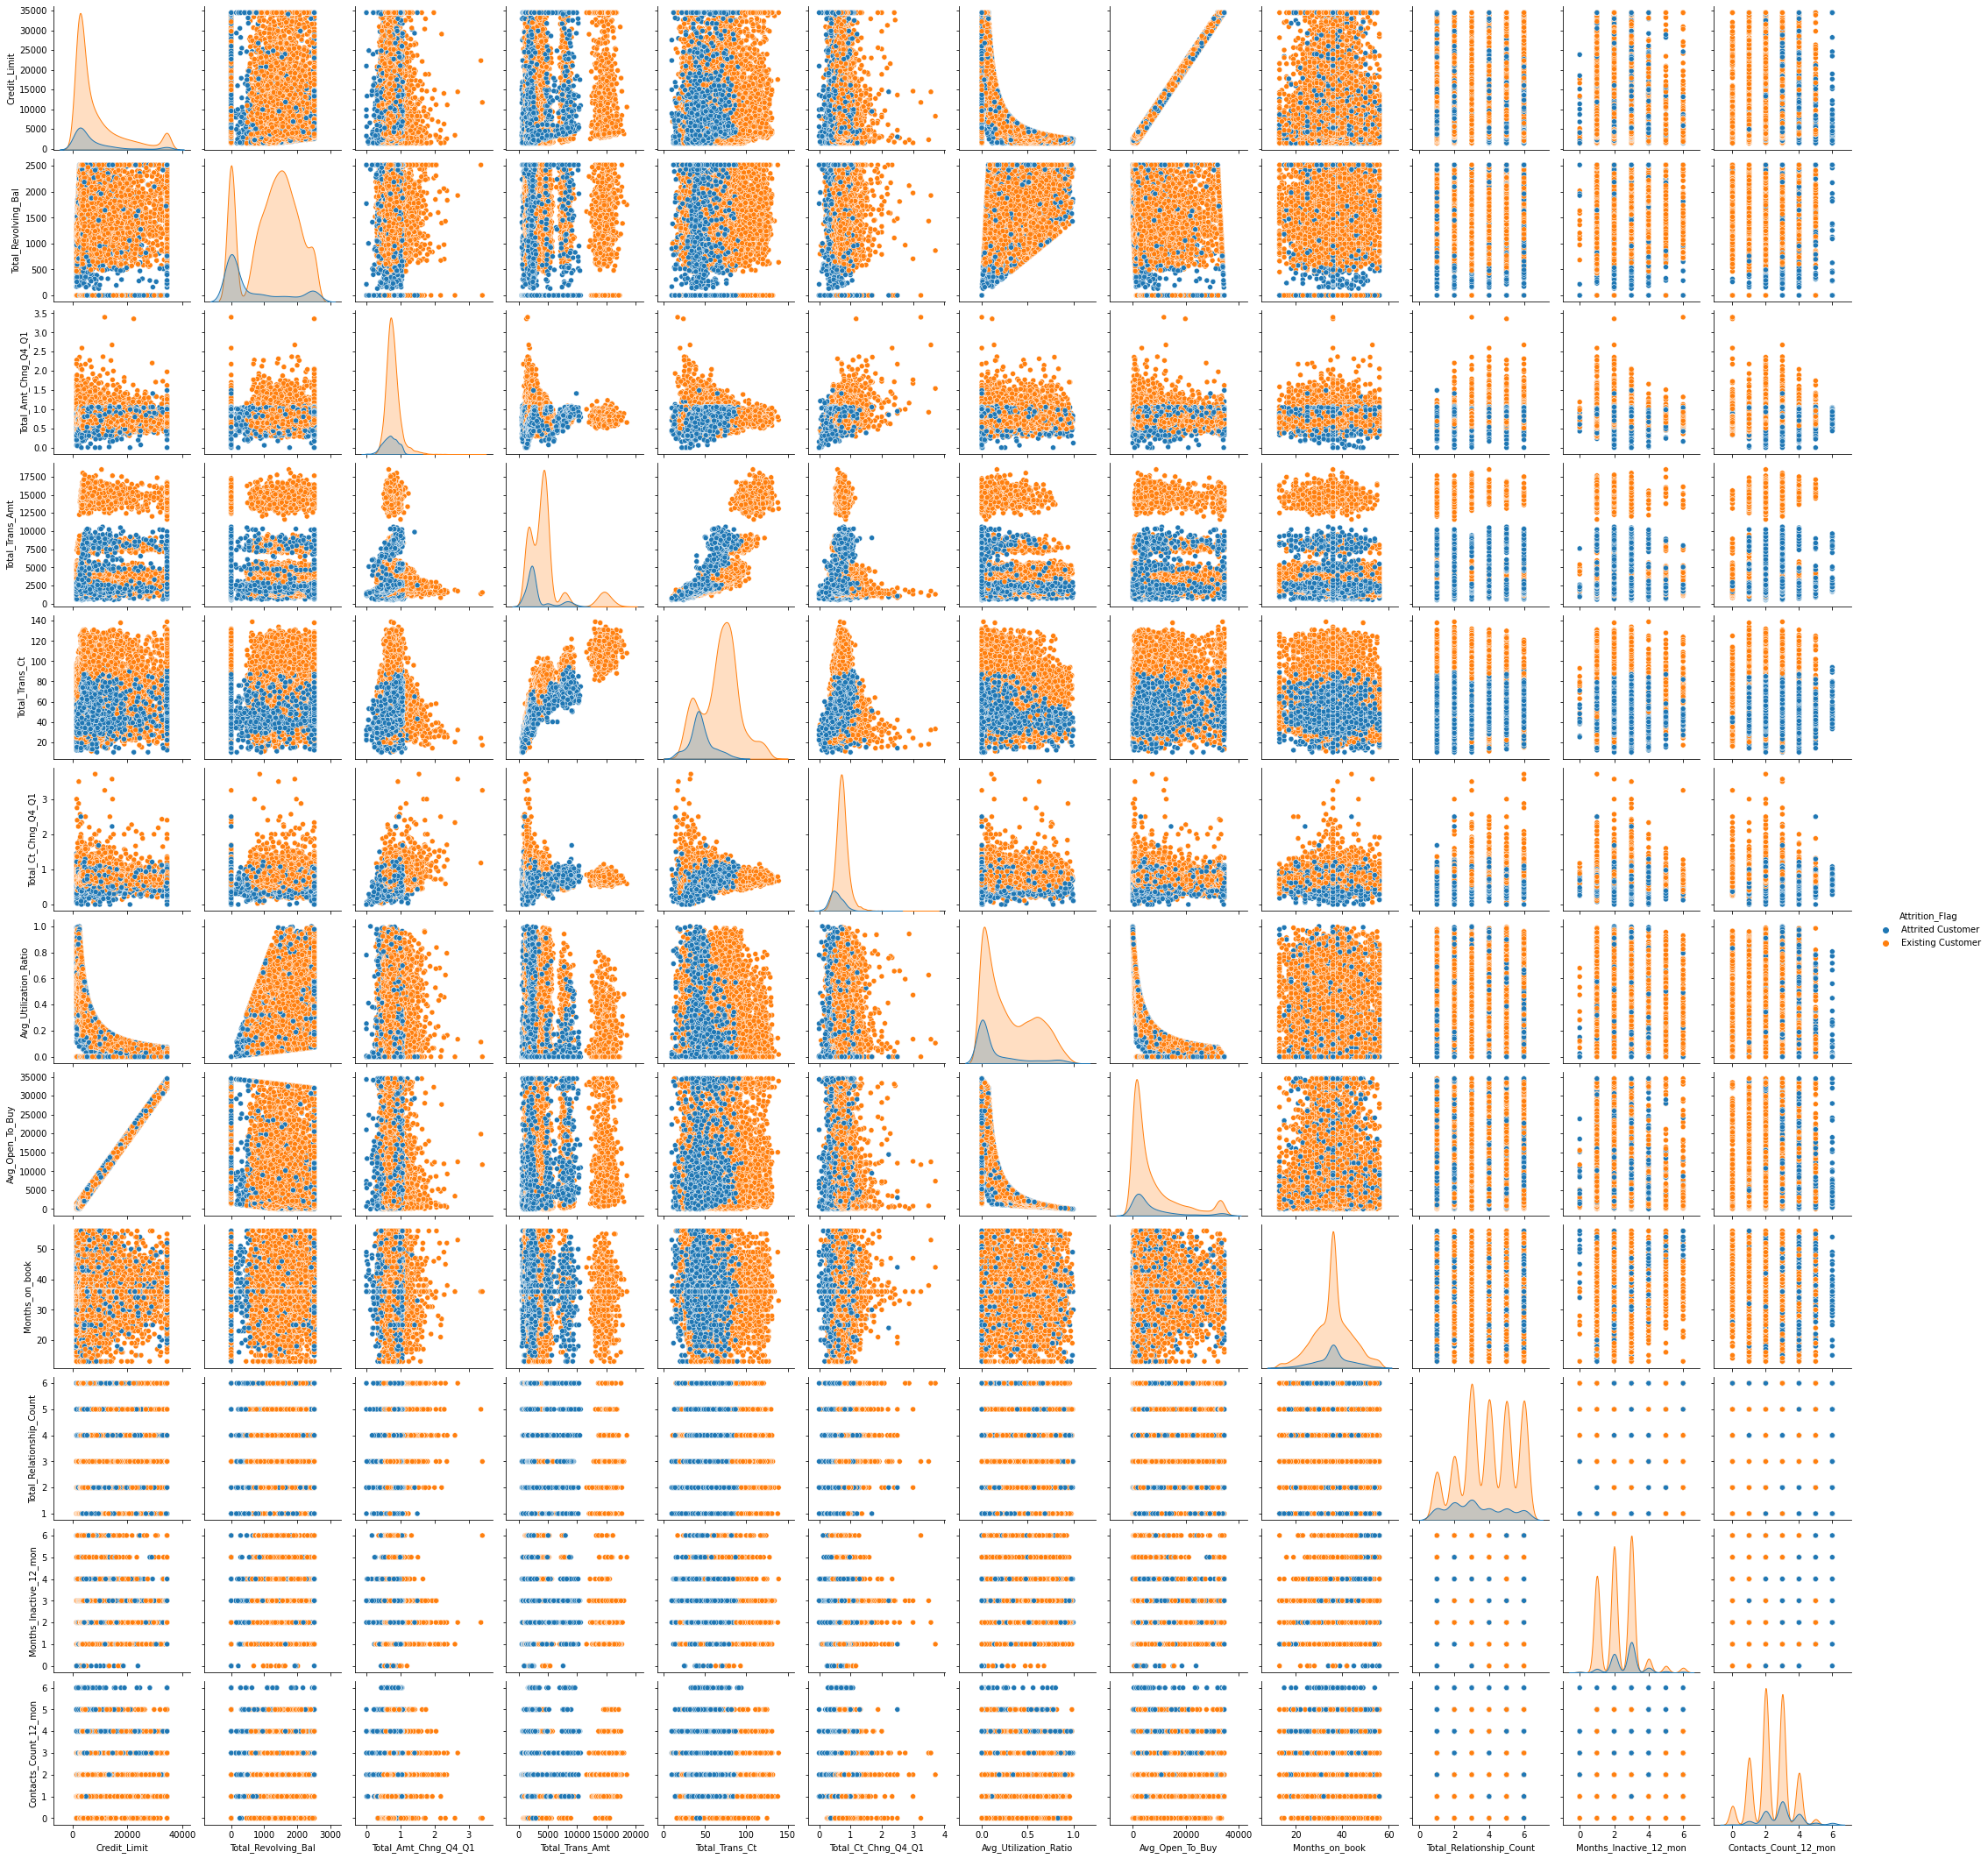

In [48]:
sns.pairplot(df[["Attrition_Flag",
                 "Credit_Limit", 
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                  "Total_Trans_Ct",
                 "Total_Ct_Chng_Q4_Q1", 
                "Avg_Utilization_Ratio",
                 "Avg_Open_To_Buy",
                 "Months_on_book",
                  'Total_Relationship_Count',
                 'Months_Inactive_12_mon',
                 'Contacts_Count_12_mon',
                ]],
             hue = "Attrition_Flag"
            )

### Interesujące wyniki analizy wizualnej:
1. Całkowita wartość tranzakcji zachowuje się podobnie(im wieksza wartość tym mniejsza szansa odejścia klienta) co całkowita ilość tranzakcji.
2. Niska wartość dla "Total_Amt_Chng_Q4_Q1" sygnalizuje możliwość odejćia klienta w ten sam sposób zachowuje się "Total_Ct_Chng_Q4_Q1"
3. Niskaw wartość utylizacja karty równiesz sugeruje możliwość odejścia klienta 
4. Wysoka ilość kontaktów z klientem sygnalizuje mozliwośc odejścia
5. Niska ilość ilośći relacji z klientem sygnalizuje możliwośc odejścia 
6. Niska ilość obrotów na koncie sygnalizuje możliwość odejścia 

### Po przeprowadzeniu wstępnej analizy przechodzimy do modelowania

# Modelowanie 

### Z analizy wiemy które zmienne są interesujące i sugerują jakich modeli możemy użyć. Ważne jest aby wybrać model który jest odporny na nie zbalansowane dane lub użyć metody do samplowania z danych terningowych z zachowaniem balansu w danych. 

### Należy sobie teraz zdać pytanie czego oczekujemy od modelu żeby model był interpretowalny czy żeby zwracał jak nalepsze wyniki ponieważ mamy tutaj trade-off wyjaśnialny model nie będzie miał dużej prezycji czy celności natomias model z dużą precyzją i celnoścą może być nie do zintepretowania. Biorąc to pod uwagę oraz wcześniejsza analize stworzymy wybrane modele: 

1. Drzewo decyzyjne 
2. Regresje logistyczną 
3. Naive bayes

### Pierwszy krok, podział danych na testowy i treningowy 

In [52]:

# nie zbalansowane dane 
from imblearn.over_sampling import SMOTE
#metryki 
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
# podiział an test-train 
from sklearn.model_selection import train_test_split
# modele
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.linear_model import LogisticRegression
# Wersja naive bayes odporna na nie zbalnsowane dane 
from sklearn.naive_bayes import GaussianNB


 ### Została wybrany tylko podzbiór zmienych, które wyglądały na interesujące w procesie analizy. 

In [54]:
selected_columns = [
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                  "Total_Trans_Ct",
                 "Total_Ct_Chng_Q4_Q1", 
                "Avg_Utilization_Ratio",
                  'Total_Relationship_Count',
                 'Contacts_Count_12_mon',
                ]


In [64]:

# oversampling do zbalansowania danych 
sm = SMOTE()

X, y = sm.fit_resample(df[selected_columns], df["Attrition_Flag_onehot"])


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

print(f"Balans zmiennych PRZED oversamplingu  {(df['Attrition_Flag_onehot'] == 1).sum()/(df['Attrition_Flag_onehot'] == 0).sum()} ")
print(f"Balans zmiennych PO oversamplingu  {(y == 0).sum()/(y == 1).sum()} ")

Balans zmiennych PRZED oversamplingu  0.19141176470588236 
Balans zmiennych PO oversamplingu  1.0 


## Drzewo decyzjne 

In [101]:
clf_max3 = DecisionTreeClassifier(max_depth = 3)

clf_max3.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3)

In [95]:

export_graphviz(clf_max3, out_file="tree.dot", class_names=["Otwarte konto", "Zamknięte konto"],feature_names= X.columns, impurity=False, filled=True)

!dot -Tpng tree.dot -o tree_limited.png -Gdpi=1200

Image(filename = "tree_limited.png")


Interpretacja drzewa polaga na przejściu przez drzewo sprawdzają podane warunki. Im mocniejszy kolor tym większą pewnośc mamy w poprawnym przewidzeniu. 
### Interpretacja wyników 
1. całkowita ilość tranzakcji okazała się najbardziej znacząca zmienną
2. Jeśli mamy niską ilość tranzakcji oraz obrotów to ilość poroduktów posiadanych przez klienta dobrze pozwala nam określić zamknie konto. 
3. Idą po gałęzi najbardziej na lewo widzimi bardzo dobrą klasyfikacje dla klienta nie katywengo z dużym prawdopbienstwem odejścia i odwrtoną sytułacje gdy idziemy gałęzią najbardziej w prawo. 

In [102]:
pred_dtc = clf_max3.predict(X_test)
conf_dec_tree = confusion_matrix(y_test,pred_dtc )

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )

score_desion_max3_balanced = pd.DataFrame(
[accuracy_score(y_test,pred_dtc),
f1_score(y_test,pred_dtc)
],index= ["Accuracy", "f1_score"], columns=["Drzewo decyzjne o głebokości 3"]
)
display(score_desion_max3_balanced)


Predicted True  Prediced False
Acucal True            1596              80
Acual False             401            1323

Drzewo decyzjne o głebokości 3
Accuracy                        0.858529
f1_score                        0.846178

In [97]:
clf_balanced = DecisionTreeClassifier()

clf_balanced.fit(X_train, y_train)
pred_dtc = clf_balanced.predict(X_test)
conf_dec_tree_balanced = confusion_matrix(y_test,pred_dtc )

display(pd.DataFrame(conf_dec_tree_balanced,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_decison_balanced = pd.DataFrame(
[accuracy_score(y_test,pred_dtc),
f1_score(y_test,pred_dtc)
],index= ["Accuracy", "f1_score"], columns=[f"Drzewo decyzjne o głebokości {clf_balanced.get_depth()} "]
)
display(score_decison_balanced)


DecisionTreeClassifier()

Predicted True  Prediced False
Acucal True            1601              75
Acual False             100            1624

Drzewo decyzjne o głebokości 20 
Accuracy                          0.948529
f1_score                          0.948875

### eksperyment na nie zbalansowanych danych 

In [98]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(df[selected_columns], df["Attrition_Flag_onehot"] , test_size=0.2, random_state=42)


clf_unbalanced = DecisionTreeClassifier()

clf_unbalanced.fit(X_train_u, y_train_u)


pred_dtc_u = clf_unbalanced.predict(X_test_u)
conf_dec_tree = confusion_matrix(y_test_u,pred_dtc_u )

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_deison_unbalanced = pd.DataFrame(
[accuracy_score(y_test_u,pred_dtc_u),
f1_score(y_test_u,pred_dtc_u)
],index= ["Accuracy", "f1_score"], columns=[f"Drzewo decyzjne o głebokości {clf_unbalanced.get_depth()} "]
)
display(score_deison_unbalanced)


DecisionTreeClassifier()

Predicted True  Prediced False
Acucal True            1632              67
Acual False              64             263

Drzewo decyzjne o głebokości 19 
Accuracy                          0.935341
f1_score                          0.800609

## Wnioski z modelu 
1. Model który jest prosty nie ma tak dobrych metryk jak model bardziej skomplikowany ale jest wyjaśnialny. 
2. Oversampling danych znacząco polepsza wyniki modelu, i usuwa baias na bardziej popularna klasę, co widzimy po spadku f1_score, przy porównaniu modeli na zbalansownaych i nie zbalansowanych danych. 
3. Analiza dużego modelu jest możliwa jednak jest ona dosyć skomplikowana ze wzgledu na dużą wielkość drzewa decyzyjnego.


## Regresja logistyczna

In [155]:
from sklearn import preprocessing



logit_model = LogisticRegression().fit(X_train,y_train)



logit_pred = logit_model.predict(X_test)

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [158]:



conf_logit = confusion_matrix(y_test,pred_logit )



display(pd.DataFrame(conf_logit,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_logit= pd.DataFrame(
[accuracy_score(y_test,pred_logit),
f1_score(y_test,pred_logit)
],index= ["Accuracy", "f1_score"], columns=[f"Regresja logistyczna"]
)
display(score_logit)

Predicted True  Prediced False
Acucal True            1417             259
Acual False             265            1459

Regresja logistyczna
Accuracy              0.845882
f1_score              0.847763

In [178]:

for i, c in enumerate(X_train.columns):
    prob = 1-np.exp(logit_model.coef_[0][i])
    print(f" Parametr dla {c} sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o {prob:.4f}% ")


 Parametr dla Total_Revolving_Bal sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o 0.0007% 
 Parametr dla Total_Amt_Chng_Q4_Q1 sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o -1.8612% 
 Parametr dla Total_Trans_Amt sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o -0.0003% 
 Parametr dla Total_Trans_Ct sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o 0.0767% 
 Parametr dla Total_Ct_Chng_Q4_Q1 sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o 0.5912% 
 Parametr dla Avg_Utilization_Ratio sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o -0.2121% 
 Parametr dla Total_Relationship_Count sprawia że zmiana wartości o 1 parametru oznacza zmiane prawdopobieństwa na odejście o 0.3479% 
 Parametr dla Contacts_Count_12_mon sprawia że zmiana wartości o 1 parametru oznacza zmi

### Interpetacja wyników
Regresja logistyczna dała nam zadawalajace wyniki przy czym każdy jej parametr jest interptetowalny. 

## Naive bayes 

In [125]:

clf_bayes = GaussianNB()
clf_bayes.fit(X_train ,y_train)

pred_bayes = clf_bayes.predict(X_test)
conf_dec_tree = confusion_matrix(y_test,pred_bayes)

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_bayes = pd.DataFrame(
[accuracy_score(y_test,pred_bayes),
f1_score(y_test,pred_bayes)
],index= ["Accuracy", "f1_score"], columns=[f"Naive bayes zbalansowane dane"]
)
display(score_bayes)

GaussianNB()

Predicted True  Prediced False
Acucal True            1277             399
Acual False             348            1376

Naive bayes zbalansowane dane
Accuracy                       0.780294
f1_score                       0.786510

Predicted True  Prediced False
Acucal True            1574             125
Acual False             131             196

Naive bayes
Accuracy     0.873643
f1_score     0.604938

In [126]:
clf_bayes_unbalanced = GaussianNB()
clf_bayes_unbalanced.fit(X_train_u ,y_train_u)

pred_bayes_unbalaned = clf_bayes_unbalanced.predict(X_test_u)
conf_dec_tree = confusion_matrix(y_test_u,pred_bayes_unbalaned)

display(pd.DataFrame(conf_dec_tree,
                     index= ["Acucal True", "Acual False"], 
                     columns= ["Predicted True", "Prediced False"]) )


score_bayes = pd.DataFrame(
[accuracy_score(y_test_u,pred_bayes_unbalaned),
f1_score(y_test_u,pred_bayes_unbalaned)
],index= ["Accuracy", "f1_score"], columns=[f"Naive bayes nie zbalansowane"]
)
display(score_bayes)

GaussianNB()

Predicted True  Prediced False
Acucal True            1574             125
Acual False             131             196

Naive bayes nie zbalansowane
Accuracy                      0.873643
f1_score                      0.604938

### Widzmy overfit  na nie zbalansowana kategorię w przypadku gdy nie balansujemy naszych danych dlatego  do interptetacji wyników użyjemy modelu trenowanego na zbalansowanych danych.

## Porównanie modeli 

## Wnisoki z analizy 